# Import Data


## Import and Install

In [1]:
%pip install scikit-surprise
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install pyspark

import pickle
import pandas as pd
import os
import urllib.request
import zipfile
from surprise import Dataset, Reader, SVD, accuracy, NMF
from surprise.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from surprise.accuracy import rmse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from pprint import pprint
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALSModel
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.model_selection import train_test_split as sk_train_test_split




[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgr

## Get Data

In [2]:
DATA_FILE = "ml-latest-small"
DATA_URL = f"https://files.grouplens.org/datasets/movielens/{DATA_FILE}.zip"
DATA_DIR = "../data"

ratings_path = os.path.join(DATA_DIR, DATA_FILE, "ratings.csv")

## Load Data

In [3]:
def _load_ratings_df():
    """
    This function loads the ratings from disk.

    Returns:
    - ratings_df: The ratings dataframe
    """
    # Check if the directory exists, if not, create it
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)

    data_path = os.path.join(DATA_DIR, f"{DATA_FILE}.zip")

    if not os.path.exists(data_path):
        print("Downloading data...")
        urllib.request.urlretrieve(DATA_URL, data_path)
        with zipfile.ZipFile(data_path, "r") as zip_ref:
            zip_ref.extractall(DATA_DIR)

    ratings_df = pd.read_csv(ratings_path)
    return ratings_df

def _load_ratings():
    """
    This function loads the ratings from disk.

    Returns:
    - train_set: The training set
    - test_set: The test set
    """

    ratings_df = _load_ratings_df()
    reader = Reader(line_format="user item rating timestamp", sep=",")
    data = Dataset.load_from_df(ratings_df[["userId", "movieId", "rating"]], reader)
    train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)
    return data, train_set, test_set

full_ratings, train_ratings, test_ratings = _load_ratings()

# Data Exploration
What data exploration methods do we need?

Mean Rating: 3.501556983616962
Median Rating: 3.5
Mode Rating: 4.0
Standard Deviation: 1.042529239060635
Varianz der Ratings: 1.086867214296347


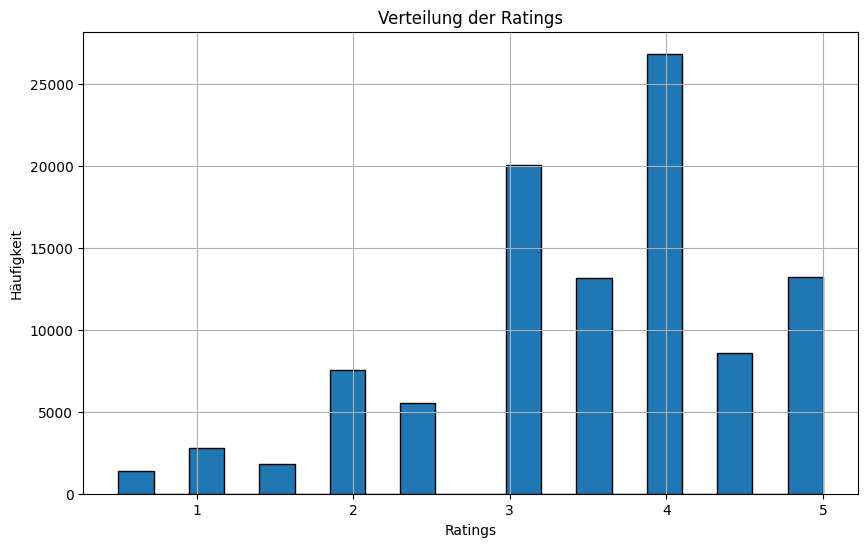

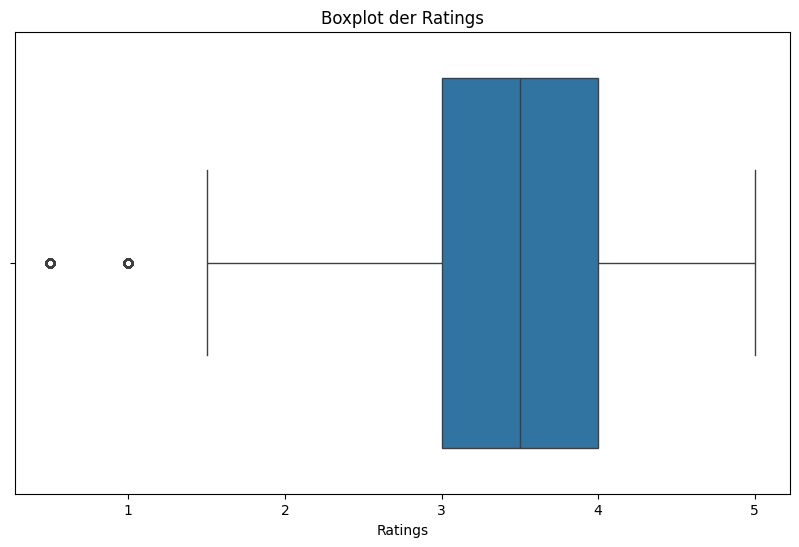

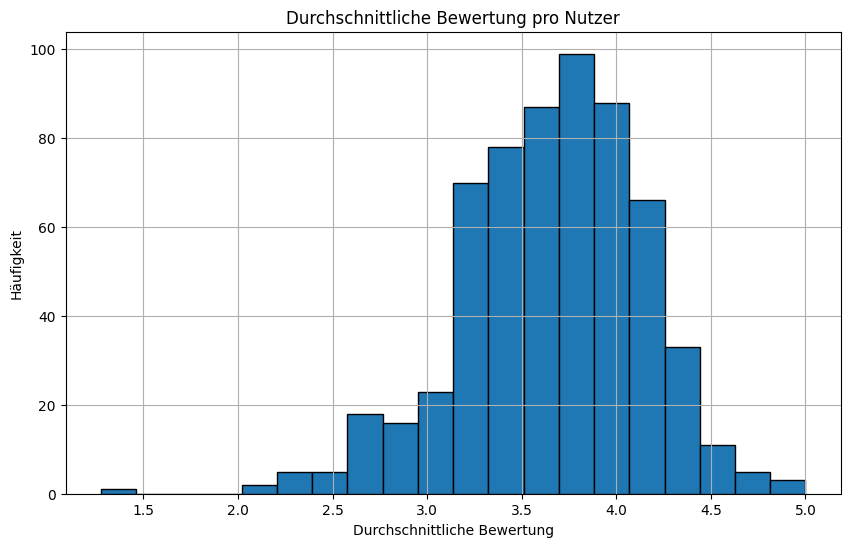

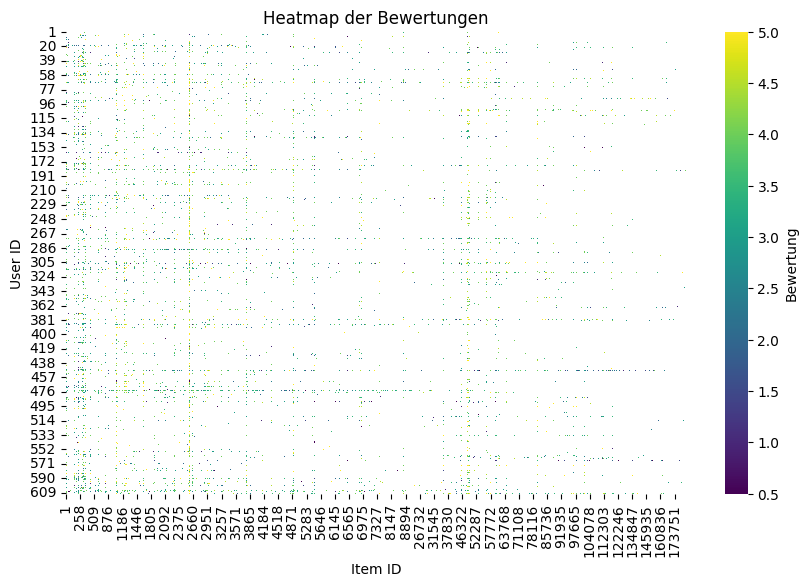

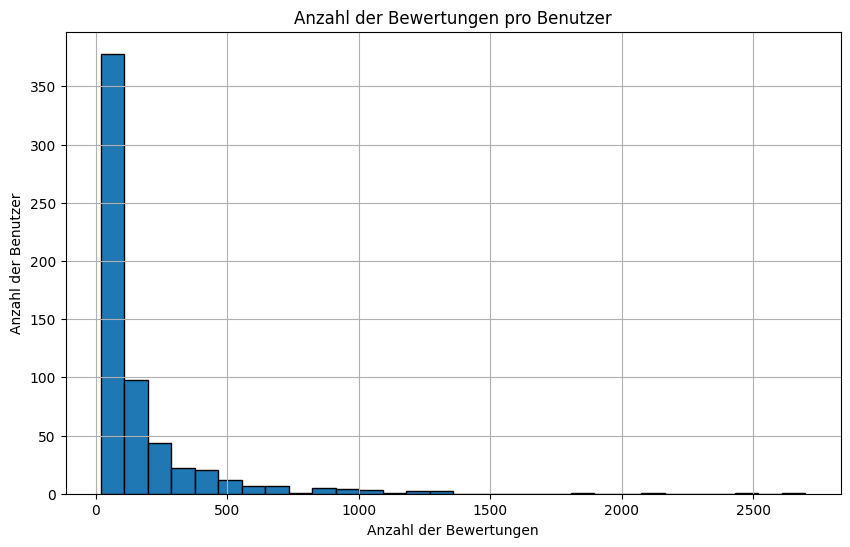

Maximale Anzahl der Bewertungen pro Benutzer: 2698
Durchschnittliche Anzahl der Bewertungen pro Benutzer: 165.30491803278687
Median der Anzahl der Bewertungen pro Benutzer: 70.5
Minimale Anzahl der Bewertungen pro Benutzer: 20


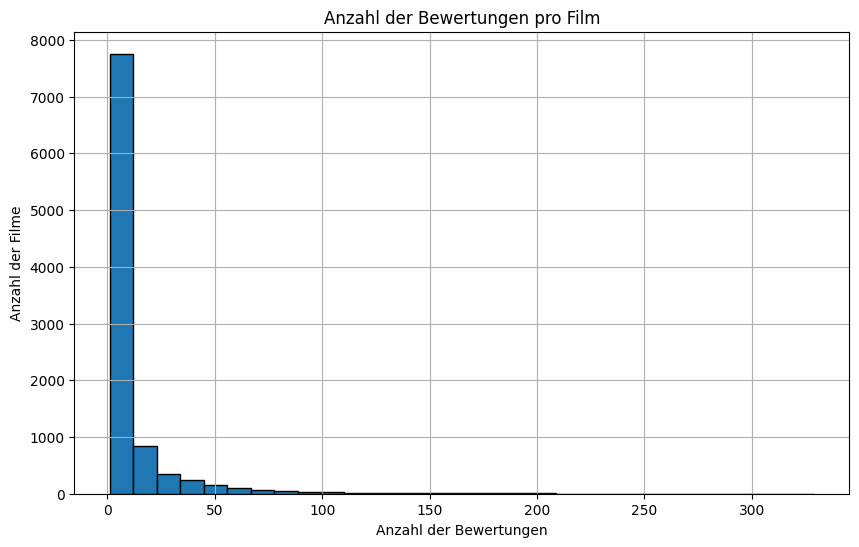

Maximale Anzahl der Bewertungen pro Film: 329
Durchschnittliche Anzahl der Bewertungen pro Film: 10.369806663924312
Median der Anzahl der Bewertungen pro Film: 3.0
Minimale Anzahl der Bewertungen pro Film: 1


In [4]:
def visualize_ratings(file_path):
    """
    Diese Funktion liest eine Datei mit Bewertungsdaten ein und zeigt die Verteilung der Ratings als Histogramm an.

    :param file_path: Der Pfad zur CSV-Datei, die die Daten enthält.
    """
    # Daten einlesen
    df = pd.read_csv(file_path)

    ratings = df["rating"]
    # Deskriptive Statistiken
    mean_rating = ratings.mean()
    median_rating = ratings.median()
    mode_rating = ratings.mode()[0]
    std_dev_rating = ratings.std()
    variance = ratings.var()

    print(f"Mean Rating: {mean_rating}")
    print(f"Median Rating: {median_rating}")
    print(f"Mode Rating: {mode_rating}")
    print(f"Standard Deviation: {std_dev_rating}")
    print(f"Varianz der Ratings: {variance}")

    # Histogramm
    plt.figure(figsize=(10, 6))
    plt.hist(ratings, bins=20, edgecolor="black")
    plt.title("Verteilung der Ratings")
    plt.xlabel("Ratings")
    plt.ylabel("Häufigkeit")
    plt.grid(True)
    plt.show()

    # Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=ratings)
    plt.title("Boxplot der Ratings")
    plt.xlabel("Ratings")
    plt.show()

    # Durchschnittliche Bewertung pro Nutzer
    user_mean_rating = df.groupby("userId")["rating"].mean()
    plt.figure(figsize=(10, 6))
    plt.hist(user_mean_rating, bins=20, edgecolor="black")
    plt.title("Durchschnittliche Bewertung pro Nutzer")
    plt.xlabel("Durchschnittliche Bewertung")
    plt.ylabel("Häufigkeit")
    plt.grid(True)
    plt.show()

    # Heatmap der Bewertungen
    pivot_table = df.pivot_table(index="userId", columns="movieId", values="rating")
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, cmap="viridis", cbar_kws={"label": "Bewertung"})
    plt.title("Heatmap der Bewertungen")
    plt.xlabel("Item ID")
    plt.ylabel("User ID")
    plt.show()

    # Anzahl der Bewertungen pro Benutzer
    ratings_per_user = df["userId"].value_counts()
    plt.figure(figsize=(10, 6))
    plt.hist(ratings_per_user, bins=30, edgecolor="black")
    plt.title("Anzahl der Bewertungen pro Benutzer")
    plt.xlabel("Anzahl der Bewertungen")
    plt.ylabel("Anzahl der Benutzer")
    plt.grid(True)
    plt.show()

    # Maximum, Mittelwert, Median und Minimum der Anzahl der Bewertungen pro Benutzer
    max_ratings = ratings_per_user.max()
    mean_ratings = ratings_per_user.mean()
    median_ratings = ratings_per_user.median()
    min_ratings = ratings_per_user.min()
    print(f"Maximale Anzahl der Bewertungen pro Benutzer: {max_ratings}")
    print(f"Durchschnittliche Anzahl der Bewertungen pro Benutzer: {mean_ratings}")
    print(f"Median der Anzahl der Bewertungen pro Benutzer: {median_ratings}")
    print(f"Minimale Anzahl der Bewertungen pro Benutzer: {min_ratings}")

    # Anzahl der Bewertungen pro Film
    ratings_per_movie = df["movieId"].value_counts()
    plt.figure(figsize=(10, 6))
    plt.hist(ratings_per_movie, bins=30, edgecolor="black")
    plt.title("Anzahl der Bewertungen pro Film")
    plt.xlabel("Anzahl der Bewertungen")
    plt.ylabel("Anzahl der Filme")
    plt.grid(True)
    plt.show()

    # Maximum, Mittelwert, Median und Minimum der Anzahl der Bewertungen pro Film
    max_ratings = ratings_per_movie.max()
    mean_ratings = ratings_per_movie.mean()
    median_ratings = ratings_per_movie.median()
    min_ratings = ratings_per_movie.min()
    print(f"Maximale Anzahl der Bewertungen pro Film: {max_ratings}")
    print(f"Durchschnittliche Anzahl der Bewertungen pro Film: {mean_ratings}")
    print(f"Median der Anzahl der Bewertungen pro Film: {median_ratings}")
    print(f"Minimale Anzahl der Bewertungen pro Film: {min_ratings}")

    return df


ratings_df = visualize_ratings(ratings_path)

Die Varianz von 1.086867214296347 zeigt, dass die Bewertungen eine moderate Streuung um den Mittelwert haben. Das ist ein guter Hinweis darauf, dass es eine gewisse Diversität in den Meinungen gibt, aber die Bewertungen sind nicht extrem weit vom Durchschnitt entfernt. Dies kann hilfreich sein, um die Präzision von Vorhersagemodellen und die Zuverlässigkeit der Bewertungen zu bewerten.

# Train & Evaluate Model

## Train SVD

In [5]:
def _save_model(model, model_name):
    """
    This function saves the trained model to disk.

    Args:
    - model: The trained model to be saved
    - model_name: The name of the model
    """
    if not os.path.exists("../models"):
        os.makedirs("../models")
    model_path = f"../models/{model_name}.pkl"
    with open(model_path, "wb") as f:
        pickle.dump(model, f)


def _train_matrix_factorization_model(ratings):
    """
    This function trains a matrix factorization model.

    Args:
    - ratings: The ratings data as Surprise dataset

    Returns:
    - matrix_factorization_model: The trained matrix factorization model
    """
    matrix_factorization_model = SVD(
        n_factors=200, n_epochs=100, lr_all=0.005, reg_all=0.1, random_state=42
    )
    matrix_factorization_model.fit(ratings)
    return matrix_factorization_model

model = _train_matrix_factorization_model(train_ratings)
_save_model(model, "matrix_factorization_model")

## Evaluate SVD

### Cross Validation

In [6]:
def _cross_validate_model(dataset, algo, n_splits=5):
    """
    Führt eine Kreuzvalidierung für ein gegebenes Modell mit Surprise durch und berechnet den durchschnittlichen RMSE.

    :param dataset: Der Surprise-Datensatz.
    :param algo: Das Modell, das validiert werden soll.
    :param n_splits: Die Anzahl der Folds für die Kreuzvalidierung.
    :return: Der durchschnittliche RMSE über alle Folds.
    """
    # Führe die Kreuzvalidierung durch
    results = cross_validate(
        algo, dataset, measures=["RMSE", "MAE"], cv=n_splits, verbose=True
    )

    # Durchschnittlicher RMSE über alle Folds
    avg_rmse = results["test_rmse"].mean()
    print(f"Durchschnittlicher RMSE über {n_splits}-Folds: {avg_rmse}")

    # Durchschnittlicher MAE über alle Folds
    avg_mae = results["test_mae"].mean()
    print(f"Durchschnittlicher MAE über {n_splits}-Folds: {avg_mae}")

    return avg_rmse

# Erstelle ein SVD-Modell
svd_model = SVD(n_factors=200, n_epochs=100, lr_all=0.005, reg_all=0.1, random_state=42)


# Rufe die Funktion mit dem DataFrame und dem SVD-Modell als Argumenten auf
_cross_validate_model(full_ratings, svd_model, n_splits=5)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8523  0.8444  0.8472  0.8452  0.8538  0.8486  0.0038  
MAE (testset)     0.6512  0.6465  0.6481  0.6493  0.6534  0.6497  0.0024  
Fit time          3.91    3.30    3.02    3.70    3.06    3.40    0.35    
Test time         0.17    0.05    0.05    0.05    0.05    0.07    0.05    
Durchschnittlicher RMSE über 5-Folds: 0.8485913256067408
Durchschnittlicher MAE über 5-Folds: 0.6497134380835774


0.8485913256067408

### Baseline Model

In [7]:
def _calculate_baseline_rmse(ratings):
    """
    Berechnet das RMSE für ein Baseline-Modell, das den Durchschnitt aller Bewertungen verwendet.

    Parameters:
    ratings : pandas DataFrame
        DataFrame mit den Spalten 'rating', 'userId', 'movieId' für Bewertungen.

    Returns:
    float : RMSE des Baseline-Modells
    """
    # Durchschnitt aller Bewertungen berechnen
    average_rating = np.mean(ratings["rating"])

    # Vorhersagen des Baseline-Modells: für jeden Eintrag den Durchschnitt verwenden
    baseline_predictions = np.full_like(ratings["rating"], average_rating)

    # RMSE zwischen den tatsächlichen Bewertungen und den Vorhersagen des Baseline-Modells berechnen
    baseline_rmse = np.sqrt(mean_squared_error(ratings["rating"], baseline_predictions))
    print(f"RMSE des Baseline-Modells: {baseline_rmse}")

    # Mean Absolute Error (MAE) berechnen
    mae = np.abs(ratings["rating"] - baseline_predictions).mean()
    print(f"MAE des Baseline-Modells: {mae}")

    return baseline_rmse


baseline_rmse = _calculate_baseline_rmse(ratings_df)

RMSE des Baseline-Modells: 1.0425240696180562
MAE des Baseline-Modells: 0.8271026565093414


### Evaluate Model

In [8]:
def _evaluate_model(model, test_ratings):
    """
    This function evaluates the trained model.

    Args:
    - model: The trained matrix factorization model
    - test_ratings: The test set
    """
    predictions = model.test(test_ratings)

    rmse_res = rmse(
        predictions
    )  # Root Mean Squared Error: This metric calculates the square root of the average of the squared errors. The lower the value, the better the model. A value of 0 indicates no error or perfect predictions.

    mae = accuracy.mae(
        predictions
    )  # Mean Absolute Error: This metric calculates the average of the absolute errors. The lower the value, the better the model.

    print(f"Matrix Factorization Model(SVD) RMSE: {rmse_res}")
    print(f"Matrix Factorization Model(SVD) MAE: {mae}")
    return rmse_res


_evaluate_model(model, test_ratings)

RMSE: 0.8544
MAE:  0.6564
Matrix Factorization Model(SVD) RMSE: 0.854393882333028
Matrix Factorization Model(SVD) MAE: 0.6563914042933294


0.854393882333028

## Hyperparameter Tuning

### Grid Search

In [9]:
def _do_a_grid_search(dataset):
    """
    This function does a grid search to find the best hyperparameters for the matrix factorization model.
    """
    trainset, testset = train_test_split(dataset, test_size=0.2)
    # param_grid = {
    #     "n_factors": [10, 20, 50, 100, 200],
    #     "n_epochs": [10, 20, 30, 50, 100],
    #     "lr_all": [0.001, 0.005, 0.01, 0.02, 0.05],
    #     "reg_all": [0.02, 0.05, 0.1, 0.2, 0.4],
    #     "lr_bu": [0.002, 0.005, 0.01],
    #     "lr_bi": [0.002, 0.005, 0.01],
    #     "lr_pu": [0.002, 0.005, 0.01],
    #     "lr_qi": [0.002, 0.005, 0.01],
    #     "reg_bu": [0.02, 0.05, 0.1],
    #     "reg_bi": [0.02, 0.05, 0.1],
    #     "reg_pu": [0.02, 0.05, 0.1],
    #     "reg_qi": [0.02, 0.05, 0.1],
    # }
    param_grid = {
        "n_factors": [10, 20, 50, 100, 200],
        "n_epochs": [10, 20, 30, 50, 100],
        "lr_all": [0.001, 0.005, 0.01, 0.02, 0.05],
        "reg_all": [0.02, 0.05, 0.1, 0.2, 0.4],
    }
    grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
    grid_search.fit(dataset)
    print(grid_search.best_params["rmse"])
    print(grid_search.best_score["rmse"])

    # Bewertung auf Testdaten
    best_params = grid_search.best_params["rmse"]
    algo = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'], random_state=0)
    algo.fit(trainset)
    predictions = algo.test(testset)
    test_rmse = accuracy.rmse(predictions)
    print(f"RMSE auf Testdaten: {test_rmse}")

    model = SVD(**grid_search.best_params["rmse"], random_state=0)
    _cross_validate_model(dataset, model, n_splits=5, )

# _do_a_grid_search(full_ratings)
# {'n_factors': 200, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}
# 0.8579646800935015
# RMSE: 0.8472
# RMSE auf Testdaten: 0.8471844852710307
# Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

#                   Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
# RMSE (testset)    0.8470  0.8530  0.8478  0.8474  0.8510  0.8492  0.0024  
# MAE (testset)     0.6499  0.6516  0.6501  0.6495  0.6533  0.6509  0.0014  
# Fit time          4.33    4.36    4.53    4.43    4.34    4.40    0.07    
# Test time         0.05    0.05    0.05    0.05    0.30    0.10    0.10    
# Durchschnittlicher RMSE über 5-Folds: 0.849240366415177
# Durchschnittlicher MAE über 5-Folds: 0.650865215104424

# Use Model

## Collaborative Filtering - Matrix Factorization


In [10]:

def _load_model(model_name):
    """
    This function loads a pre-trained model from disk.

    Args:
    - model_name: The name of the model to be loaded

    Returns:
    - model: The pre-trained model
    """
    model_path = f"../models/{model_name}.pkl"
    with open(model_path, "rb") as f:
        model = pickle.load(f)
    return model


def _find_similar_user(user_rated_movies, model, n_similar=1):
    """
    Find a similar user based on the given user's ratings using a pre-trained model.

    Parameters:
    user_rated_movies (list of dicts): List of ratings by the user in the form [{'movieId': int, 'rating': float}].
    model (AlgoBase): The pre-trained Surprise model.
    n_similar (int): The number of similar users to find. Default is 1.

    Returns:
    list: List of similar user IDs.
    """
    # Map movie IDs to the internal item IDs used by the model
    trainset = model.trainset
    temp_user_ratings = [
        (trainset.to_inner_iid(movie["movieId"]), movie["rating"])
        for movie in user_rated_movies
        if movie["movieId"] in trainset._raw2inner_id_items
    ]

    # Get the latent factors for the items rated by the temporary user
    q_i = np.array([model.qi[item_id] for item_id, _ in temp_user_ratings])
    r_ui = np.array([rating for _, rating in temp_user_ratings])

    # Calculate the implicit factors (biases can be included if the model uses them)
    user_factors = np.linalg.lstsq(q_i, r_ui, rcond=None)[0]

    # Calculate the similarity of the temporary user to all other users
    similarities = []
    for other_inner_user_id in trainset.all_users():
        other_user_factors = model.pu[other_inner_user_id]
        similarity = np.dot(user_factors, other_user_factors)
        similarities.append((similarity, trainset.to_raw_uid(other_inner_user_id)))

    # Sort the similarities in descending order and get the top n_similar users
    similarities.sort(reverse=True, key=lambda x: x[0])
    similar_users = [uid for _, uid in similarities[:n_similar]]

    return similar_users[0]


def _make_matrix_factorization_recommendations(user_ratings, cinema_movies, model) -> []:
    """
    Erstellt Empfehlungen für einen neuen Benutzer basierend auf Matrixfaktorisierung.

    Parameters:
    user_ratings : list
        Die Bewertungen des Benutzers.
    cinema_movies : list
        Die Filme im Kino.
    model : SVD
        Das trainierte Modell.

    Returns:
    results : list
        Die Empfehlungen.
    """
    similar_user = _find_similar_user(user_ratings, model, n_similar=1)
    results = []

    for movie in cinema_movies:
        res = model.predict(similar_user, movie["movieId"])
        results.append(
            {
                "movieId": movie["movieId"],
                "score": round(res.est * 20),
                "externalId": movie["externalId"],
                "title": movie["title"],
                "year": movie["year"],
            }
        )

    return results


model = _load_model("matrix_factorization_model")
user_rated_movies = [
    {
        "movieId": 1,
        "rating": 5,
        "externalId": "tt0114709",
        "title": "Toy Story",
        "year": "1995",
    },
    {
        "movieId": 2,
        "rating": 4,
        "externalId": "tt0113497",
        "title": "Babe",
        "year": "1995",
    },
    {
        "movieId": 3,
        "rating": 3,
        "externalId": "tt0113228",
        "title": "Heat",
        "year": "1995",
    },
]
cinema_movies = [
    {"movieId": 1, "externalId": "", "year": 1995, "title": "Toy Story"},
    {"movieId": 2, "externalId": "", "year": 1995, "title": "Babe"},
    {"movieId": 3, "externalId": "", "year": 1995, "title": "Heat"},
]
scores = _make_matrix_factorization_recommendations(user_rated_movies, cinema_movies, model)
pprint(scores)

[{'externalId': '',
  'movieId': 1,
  'score': 81,
  'title': 'Toy Story',
  'year': 1995},
 {'externalId': '', 'movieId': 2, 'score': 63, 'title': 'Babe', 'year': 1995},
 {'externalId': '', 'movieId': 3, 'score': 58, 'title': 'Heat', 'year': 1995}]


In [11]:
def _evaluate_similar_user(user_ratings, model):
    similar_user = _find_similar_user(user_ratings, model, n_similar=1)
    print(f"Most similar user: {similar_user}")
    user_rating_predictions_similar_user = []
    for movie in user_ratings:
        prediction = model.predict(similar_user, movie["movieId"])
        user_rating_predictions_similar_user.append(
            {
                "movieId": movie["movieId"],
                "prediction": prediction.est,
                "rating": movie["rating"],
                "title": movie["title"],
                "year": movie["year"],
            }
        )

    pprint(user_rating_predictions_similar_user)


_evaluate_similar_user(user_rated_movies, model)

Most similar user: 159
[{'movieId': 1,
  'prediction': 4.032088091920455,
  'rating': 5,
  'title': 'Toy Story',
  'year': '1995'},
 {'movieId': 2,
  'prediction': 3.140928279904486,
  'rating': 4,
  'title': 'Babe',
  'year': '1995'},
 {'movieId': 3,
  'prediction': 2.8979397584037807,
  'rating': 3,
  'title': 'Heat',
  'year': '1995'}]


# Try other algorithms

In [12]:
# Erstelle ein SVD-Modell
svd_model = SVD()

# Rufe die Funktion mit dem DataFrame und dem SVD-Modell als Argumenten auf
_cross_validate_model(full_ratings, svd_model, n_splits=5)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8703  0.8713  0.8776  0.8746  0.8803  0.8748  0.0037  
MAE (testset)     0.6684  0.6664  0.6729  0.6743  0.6762  0.6716  0.0037  
Fit time          0.41    0.41    0.45    0.68    0.61    0.51    0.11    
Test time         0.05    0.11    0.05    0.05    0.06    0.06    0.02    
Durchschnittlicher RMSE über 5-Folds: 0.8748266501734536
Durchschnittlicher MAE über 5-Folds: 0.6716146929572281


0.8748266501734536

## NMF

In [13]:
def _train_nmf_model(ratings):
    """
    This function trains a Non-negative Matrix Factorization model.

    Args:
    - ratings: The ratings data as Surprise dataset

    Returns:
    - nmf_model: The trained NMF model
    """
    # trainset = ratings.build_full_trainset()
    nmf_model = NMF(random_state=42)
    nmf_model.fit(ratings)
    return nmf_model


nmf_model = _train_nmf_model(train_ratings)
_save_model(nmf_model, "nmf_model")

def _evaluate_nmf_model(model, test_ratings):
    """
    This function evaluates the trained NMF model.

    Args:
    - model: The trained NMF model
    - test_ratings: The test set
    """
    predictions = model.test(test_ratings)

    rsme = rmse(predictions) # Root Mean Squared Error: This metric calculates the square root of the average of the squared errors. The lower the value, the better the model. A value of 0 indicates no error or perfect predictions.

    mae = accuracy.mae(predictions) # Mean Absolute Error: This metric calculates the average of the absolute errors. The lower the value, the better the model.

    print(f"NMF Model RMSE: {rsme}")
    print(f"NMF Model MAE: {mae}")
    return rsme

_evaluate_nmf_model(nmf_model, test_ratings)
_cross_validate_model(full_ratings, NMF(random_state=42), n_splits=5)

RMSE: 0.9297
MAE:  0.7129
NMF Model RMSE: 0.9296744177983901
NMF Model MAE: 0.7128896925813231
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9234  0.9219  0.9173  0.9220  0.9217  0.9213  0.0021  
MAE (testset)     0.7062  0.7069  0.7028  0.7066  0.7060  0.7057  0.0015  
Fit time          0.92    1.02    0.74    0.91    0.79    0.87    0.10    
Test time         0.15    0.06    0.18    0.05    0.04    0.09    0.06    
Durchschnittlicher RMSE über 5-Folds: 0.9212732109285302
Durchschnittlicher MAE über 5-Folds: 0.7057177309146635


0.9212732109285302

## ALS

In [14]:
def _train_als_model(ratings_df):
    """
    Train a matrix factorization model using Alternating Least Squares (ALS).

    Parameters:
    ratings_df : pandas DataFrame
        DataFrame with columns 'userId', 'movieId', 'rating' for ratings.
    Returns:
    The trained ALS model.
    """

    # Create a Spark session
    spark = SparkSession.builder.appName("ALSExample").getOrCreate()

    df = spark.createDataFrame(ratings_df)

    # Train the ALS model
    als = ALS(maxIter=10, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating")
    als_model = als.fit(df)

    # als_model.save("../models/als_model")
    return als_model

# Load the ratings data
ratings_df = _load_ratings_df()
train_df, test_df = sk_train_test_split(ratings_df, test_size=0.3, random_state=42)
als_model = _train_als_model(train_df)

def _evaluate_als_model(model, ratings_df):
    """
    Evaluate the ALS model.

    Parameters:
    model : ALSModel
        The trained ALS model.
    ratings_df : pandas DataFrame
        DataFrame with columns 'userId', 'movieId', 'rating' for ratings.
    """

    spark = SparkSession.builder.appName("ALSExample").getOrCreate()
    df = spark.createDataFrame(ratings_df)

    # Generate predictions
    predictions = model.transform(df)
    predictions = predictions.na.drop()

    # Calculate RMSE
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName("mae").evaluate(predictions)

    print(f"ALS Model RMSE: {rmse}")
    print(f"ALS Model MAE: {mae}")

_evaluate_als_model(als_model, test_df)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/08 21:29:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/08 21:29:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/07/08 21:29:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/07/08 21:29:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/07/08 21:30:04 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


ALS Model RMSE: 0.9025048804703559
ALS Model MAE: 0.6933970953873
